In [1]:
%matplotlib inline

In [2]:
import nengo
import numpy as np
from math import factorial

In [623]:
n_max = 140
c = 0.05
tau_star_min = -0.02
tau_stars = tau_star_min * (1 + c)**np.arange(n_max)

k = 8
#k = 10
ss = -k / tau_star_min / (1 + c)**(np.arange(n_max + 2 * k) - k)
ss_ = ss[k:-k]
ss_diff = np.diff(ss)
ss_diff2 = ss_diff[:-1] + ss_diff[1:]
f1 = ss_diff[:-1] / ss_diff[1:] / ss_diff2
f2 = ss_diff[1:] / ss_diff[:-1] / ss_diff2
a_ = np.diag(-np.concatenate((f2, (0,))), k=-1)
b_ = np.diag(np.concatenate(((0,), f2 - f1, (0,))))
c_ = np.diag(np.concatenate(((0,), f1)), k=1)
D1 = (a_ + b_ + c_)[1:-1]
Dk = np.eye(D1.shape[1])
for i in range(k):
    if i > 0:
        Dk = D1[i:-i, i:-i] @ Dk
    else:
        Dk = D1 @ Dk

Lk = (-1)**k / factorial(k) * (ss_[:, None])**(k+1) * Dk

In [624]:
tau_stars

array([ -0.02      ,  -0.021     ,  -0.02205   ,  -0.0231525 ,
        -0.02431013,  -0.02552563,  -0.02680191,  -0.02814201,
        -0.02954911,  -0.03102656,  -0.03257789,  -0.03420679,
        -0.03591713,  -0.03771298,  -0.03959863,  -0.04157856,
        -0.04365749,  -0.04584037,  -0.04813238,  -0.050539  ,
        -0.05306595,  -0.05571925,  -0.05850521,  -0.06143048,
        -0.064502  ,  -0.0677271 ,  -0.07111345,  -0.07466913,
        -0.07840258,  -0.08232271,  -0.08643885,  -0.09076079,
        -0.09529883,  -0.10006377,  -0.10506696,  -0.11032031,
        -0.11583632,  -0.12162814,  -0.12770955,  -0.13409502,
        -0.14079977,  -0.14783976,  -0.15523175,  -0.16299334,
        -0.17114301,  -0.17970016,  -0.18868516,  -0.19811942,
        -0.20802539,  -0.21842666,  -0.229348  ,  -0.2408154 ,
        -0.25285617,  -0.26549897,  -0.27877392,  -0.29271262,
        -0.30734825,  -0.32271566,  -0.33885144,  -0.35579402,
        -0.37358372,  -0.3922629 ,  -0.41187605,  -0.43

In [673]:
dt = 0.001

#ss = np.array([.5, 0.4])

A = np.diag(-ss) * dt
B = np.ones((len(ss), 1)) * dt
C = np.eye(len(ss))
D = np.zeros((len(ss), 1))

#A = [[-2, -1], [1, 0]]
#B = [[1], [0]]
#C = [[1, 2]]
#D = 1

In [675]:
assert not np.any(A < -1.)

In [676]:
#A = np.maximum(A, -1.)

In [677]:
#A, B, C, D, dt = cont2discrete((A, B, C, D), dt=dt)

In [689]:
with nengo.Network() as model:
    inp = nengo.Node(lambda t: 1 < t <= 3 or 6 < t < 7)
    state = nengo.networks.EnsembleArray(150, len(ss), neuron_type=nengo.Direct())
    #state = LinearNetwork((A, B, C, D), 150, dt=dt, neuron_type=nengo.Direct(), synapse=0.)
    nengo.Connection(inp, state.input, transform=B, synapse=None)
    nengo.Connection(state.output, state.input, transform=np.eye(len(ss)) + A, synapse=0.)
    output = nengo.Node(size_in=len(tau_stars))
    nengo.Connection(state.output, output, transform=Lk)
    
    p_in = nengo.Probe(inp)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)

In [690]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

Building finished in 0:00:01.                                                                                           


/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Simulating finished in 0:00:05.                                                                                         


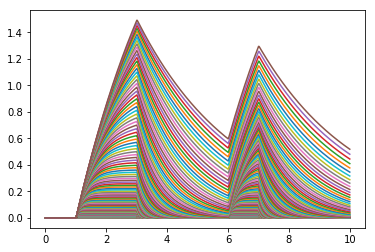

In [691]:
plt.plot(sim.trange(), sim.data[p_state][:, :]);
#plt.ylim(0.0009, 0.0011)
#plt.xlim(2.9, 3.1)

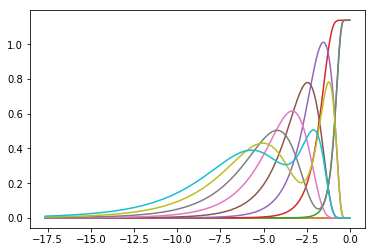

In [696]:
plt.plot(tau_stars, sim.data[p_out].T[:, ::1000]);

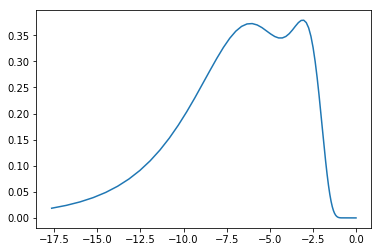

In [693]:
t = -1
plt.plot(tau_stars, Lk[:, ::] @ sim.data[p_state][t])